## Feedforward Neural Networks - MNIST Dataset

In [1]:
from Plot import plot_image_grid
import torchvision.transforms as transforms    
import torchvision.datasets as datasets        
from torch.utils.data import DataLoader         
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 🍳 Data Preparation

We'll be training on the MNIST dataset which has 60K images of handwritten numbers ranging from 0 to 9.

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.08MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 658kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.92MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.69MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



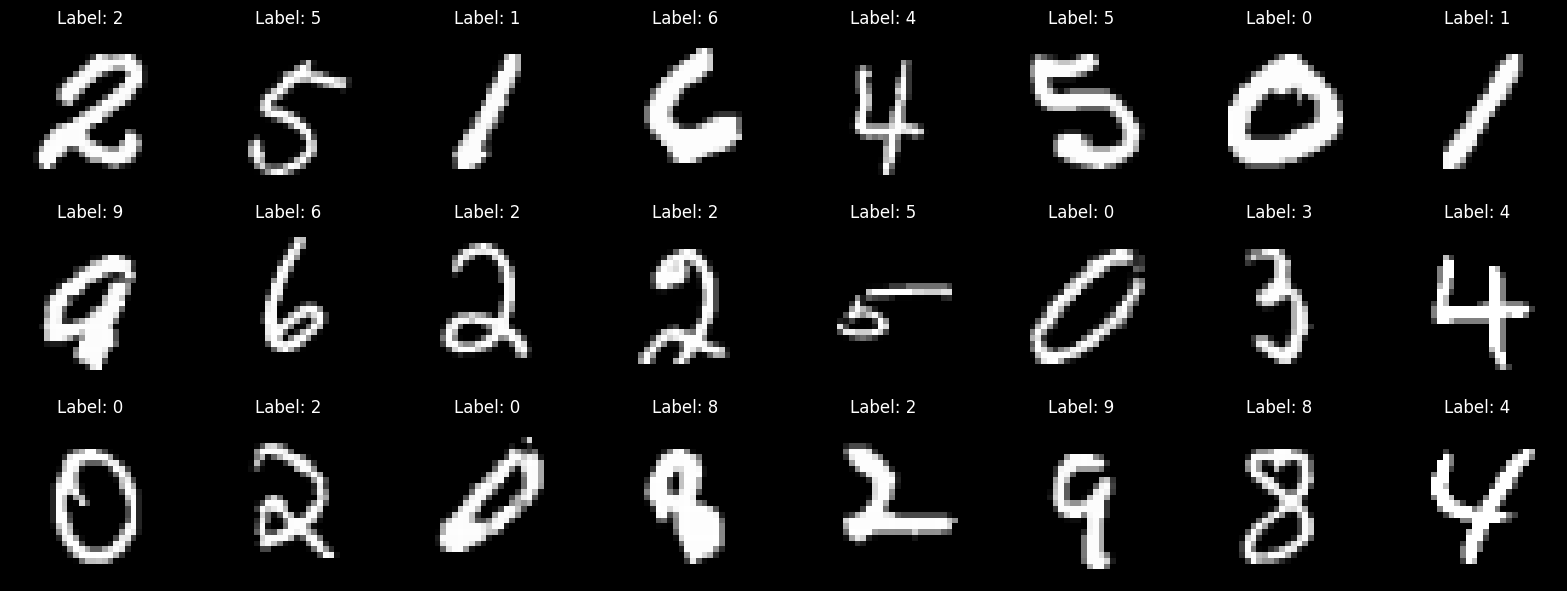

In [2]:
batch_size = 100

# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader: To be converted to batched of shape [100, 1, 28, 28]
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

plot_image_grid(train_dataset)

## 🚢 Model Building

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        
        # Architecture
        self.layers= nn.Sequential(
        nn.Flatten(),                                       # Flattening the 28x28 image into a 784 vector
        nn.Linear(input_size, hidden_size), nn.Dropout(p=0.0), nn.ReLU(),                          
        nn.Linear(hidden_size, output_size)                 # Ask yourself, why?
        )

        # Loss Function
        self.criterion = nn.CrossEntropyLoss()
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.002)

    
    def forward(self, x):
        logits = self.layers(x)
        return logits   

In [4]:
input_size, hidden_size, num_classes = 784, 500, 10
model = NeuralNet(input_size, hidden_size, num_classes).to(device)   
model

NeuralNet(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): Dropout(p=0.0, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
  (criterion): CrossEntropyLoss()
)

## 💪 Model Training

In [5]:
from tqdm.notebook import tqdm

NUM_EPOCHS = 3
num_batches = len(train_loader)
with tqdm(range(NUM_EPOCHS), desc="Epochs") as epoch_bar:
    for epoch in epoch_bar:
        total_loss, num_correct = 0.0, 0
        for i, (xb, yb) in enumerate(train_loader):
            
            # 0. Move to GPU
            xb, yb = xb.to(device), yb.to(device)
            if i == 0: assert xb.shape == (batch_size, 1, 28, 28)
            
            # 1. Forward pass
            ŷb = model(xb)
            if i == 0: assert ŷb.shape == (batch_size, 10)
            loss = model.criterion(ŷb, yb)

            # 2. Backward pass
            loss.backward()
            
            # 3. Optimization step
            model.optimizer.step()
            model.optimizer.zero_grad()

            # 4. Statistics:
            total_loss += loss.item()
            ŷb = ŷb.argmax(dim=1)
            num_correct += (ŷb == yb).sum().item()
         
        # 5. Logging:
        loss = total_loss / num_batches
        accuracy = num_correct / (num_batches * train_loader.batch_size)
        epoch_bar.set_postfix(loss=loss, accuracy = accuracy)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

## 🕵️ Evaluation

Let's loop and test all validation data:

In [6]:
with torch.no_grad():
    num_correct = 0
    for xb, yb in val_loader:
        # 0. Move to GPU
        xb, yb = xb.to(device), yb.to(device)
        # 1. Forward pass
        ŷb = model(xb)                       # (batch_size, num_classes)
        # 2. Statistics 
        ŷb = ŷb.argmax(1)      
        num_correct += (ŷb == yb).sum().item()

    acc = 100.0 * num_correct / len(val_dataset)
    print(f'Accuracy: {acc} %')

Accuracy: 97.86 %


### 💻 Deployment

In [7]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

# Load the model
loaded_model = NeuralNet(input_size, hidden_size, num_classes).to(device)   
loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model = loaded_model.to(device)
loaded_model.eval()

/var/folders/_4/h_zdrstn11z5jggdm7rz92p00000gn/T/ipykernel_96299/3755439921.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('mode

NeuralNet(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): Dropout(p=0.0, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
  (criterion): CrossEntropyLoss()
)

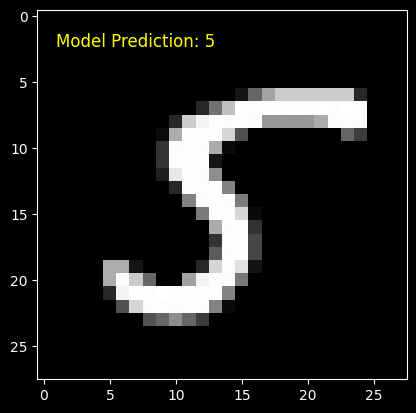

In [12]:
rand_num = torch.randint(0, 10000, (1,)).item()
rand_val_img, _ = val_dataset[rand_num]
plt.imshow(rand_val_img[0], cmap='gray')
prediction = loaded_model(rand_val_img.to(device).unsqueeze(0)).argmax(dim=1).item()
plt.text(0.05, 0.9, f'Model Prediction: {prediction}', color="yellow", transform=plt.gca().transAxes, fontsize=12)
plt.show()